In [1]:
# いつも使うやつ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interp
import seaborn as sns

# pandasで全ての列を表示
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# 図をipython notebook内で表示
%matplotlib inline

# DeplicatedWarningを避けるため
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)

import sys
sys.path.append('./lib/')

# 交差検定をサクッとやるためのモジュールを読み込む
from sklearn.cross_validation import cross_val_score

# 説明変数つくるための関数
import feature_process_helper
import get_data
import learn
import my_validate

# submissionを書き込む関数
import write_submission

/Users/k.tamashiro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/k.tamashiro/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# データをそれぞれ読み込む
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [29]:
# ticketの重複を数える関数を作成
_duplicated = train_df[train_df['Ticket'].duplicated() | train_df['Ticket'].duplicated(keep='last')].groupby(['Ticket'], as_index=False)[['PassengerId']].count()
def replace_ticket_duplicated_count(_series):
    _is = _duplicated[_series == _duplicated['Ticket']]['PassengerId']
    if _is.empty == False:
        return int(_is)
    return 0

train_df['TicketCount'] = train_df['Ticket'].apply(replace_ticket_duplicated_count)

In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


ヘルパーファイルに追加したのでおｋ

In [152]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.apply_ticket_count(train, test)
train ,test = feature_process_helper.ticket_length(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size'])
train, test = feature_process_helper.drop(train, test, bye = ['Ticket'])

test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [153]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,TicketCount,Ticket_Len,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Pclass_3,Pclass_1,Pclass_2,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
0,1,0,22.0,1,0,7.2500,23,0,0,9,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,2,1,38.0,1,0,71.2833,51,0,0,8,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,1,26.0,0,0,7.9250,22,0,0,16,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,4,1,35.0,1,0,53.1000,44,0,2,6,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,5,0,35.0,0,0,8.0500,24,0,0,6,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [154]:
target_parameter = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_3', 'Pclass_1', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'TicketCount']

ランダムフォレストのベストパラメータ

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [155]:
# 決定木で効いてそうなのを確認する
from sklearn import tree
tree_model = tree.DecisionTreeClassifier(max_depth=5)
tree_model.fit(train.loc[:, target_parameter], train.iloc[:, 1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

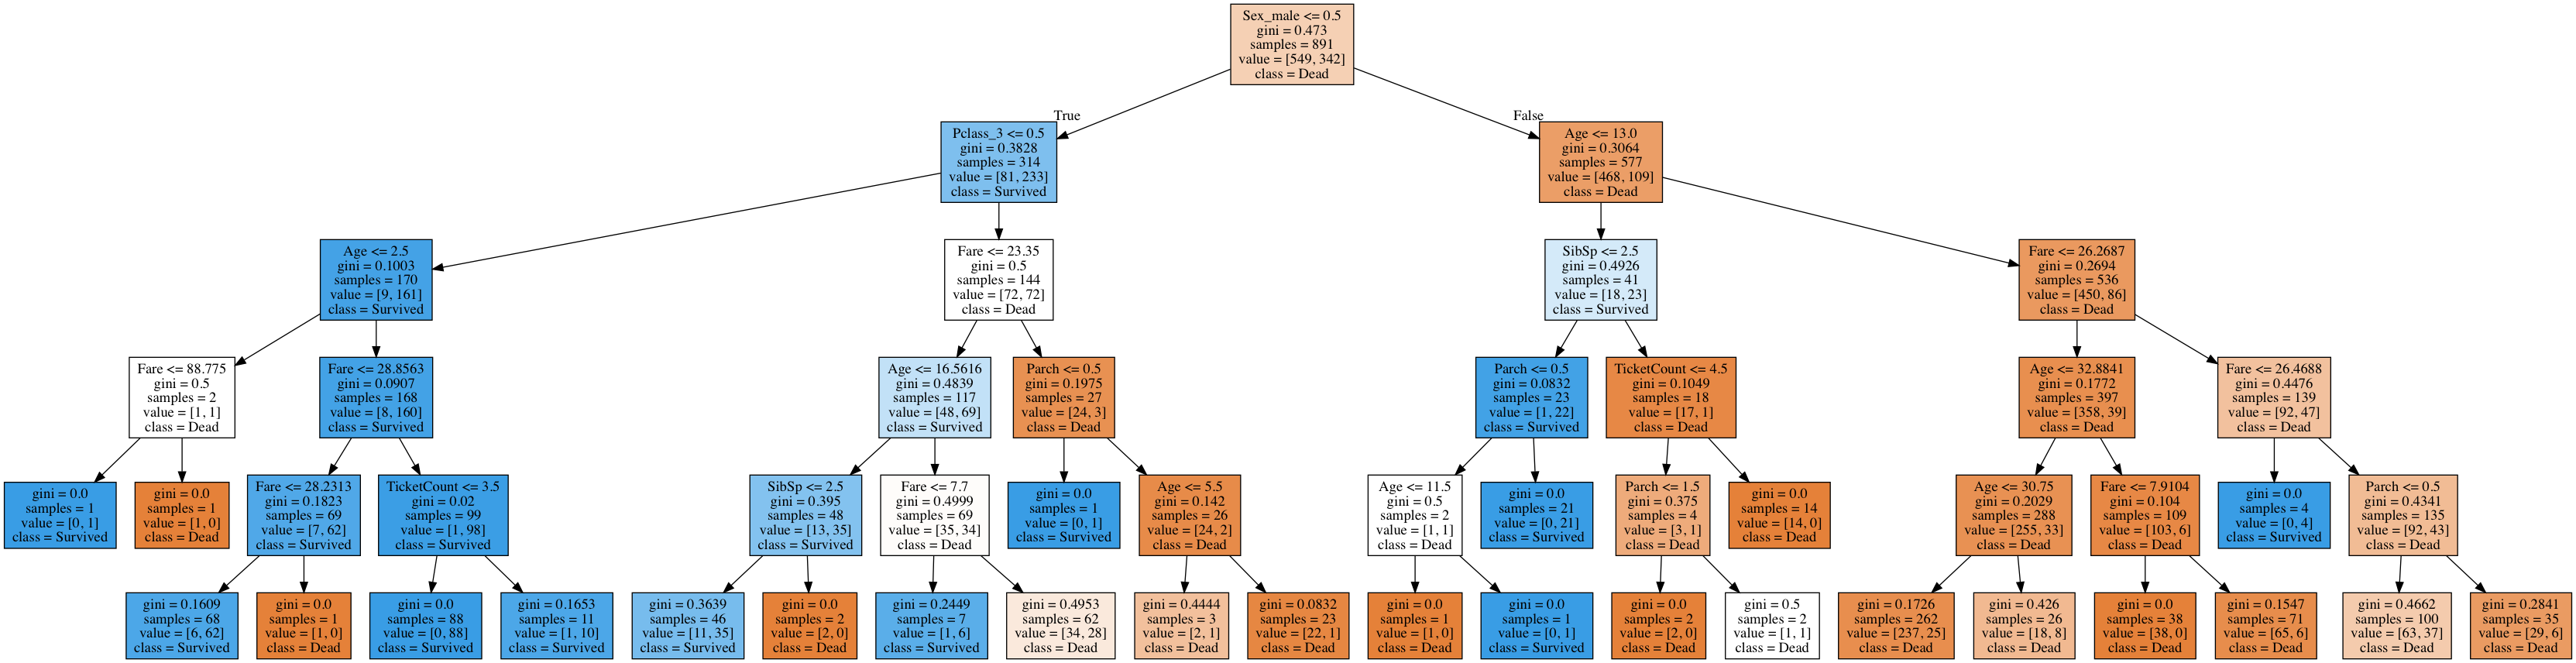

In [156]:
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO
dot_data = StringIO()
tree.export_graphviz(tree_model, out_file=dot_data, feature_names=target_parameter, class_names=['Dead', 'Survived'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [157]:
cv_scores = cross_val_score(tree_model, train.loc[:, target_parameter], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.808 +/- 0.043


In [158]:
my_validate.cross(train.loc[:, 'Survived'], tree_model.predict(train.loc[:, target_parameter]))

正解: 759
正解で生存を当てた: 229
正解で死亡を当てた: 530
予期しない: 19
欠落した: 113
間違い: 132


In [159]:
my_validate.matrix(train.loc[:, 'Survived'], tree_model.predict(train.loc[:, target_parameter]))

[[530  19]
 [113 229]]


In [160]:
# ランダムフォレストでも確認する
best_params_ = {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
rf_model = learn.learn(train.loc[:, target_parameter], train.iloc[:, 1], parameter=best_params_)

In [161]:
cv_scores = cross_val_score(rf_model, train.loc[:, target_parameter], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.827 +/- 0.054


In [162]:
pd.concat((pd.DataFrame(train.loc[:, target_parameter].columns, columns = ['variable']), 
           pd.DataFrame(rf_model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
6,Sex_male,0.291451
3,Fare,0.215613
0,Age,0.212245
4,Pclass_3,0.070067
9,TicketCount,0.063508
5,Pclass_1,0.042005
1,SibSp,0.040483
2,Parch,0.033251
7,Embarked_C,0.017487
8,Embarked_Q,0.013890


In [163]:
my_validate.cross(train.loc[:, 'Survived'], rf_model.predict(train.loc[:, target_parameter]))

正解: 814
正解で生存を当てた: 285
正解で死亡を当てた: 529
予期しない: 20
欠落した: 57
間違い: 77


In [164]:
my_validate.matrix(train.loc[:, 'Survived'], rf_model.predict(train.loc[:, target_parameter]))

[[529  20]
 [ 57 285]]


In [165]:
# 関数化したけどロードめんどいのでここで
pre_core_df = my_validate.create_correct(train.loc[:, 'Survived'], rf_model.predict(train.loc[:, target_parameter]))
correct = pre_core_df['correct']
predict = pre_core_df['predict']

tp = train.iloc[pre_core_df[(correct == predict) & (1 == predict)].index, ]
tn = train.iloc[pre_core_df[(correct == predict) & (0 == predict)].index, ]
fp = train.iloc[pre_core_df[(correct != predict) & (0 != predict)].index, ]
fn = train.iloc[pre_core_df[(correct != predict) & (1 != predict)].index, ]

print(tp['Survived'].count(), ':', tn['Survived'].count(), ':', fp['Survived'].count(), ':', fn['Survived'].count())

285 : 529 : 20 : 57


fnを2つ修正できました！（死亡の外しを２つ修正できた）

In [166]:
predictions = rf_model.predict(test.loc[:, target_parameter])
predictions = pd.DataFrame(predictions, columns=['Survived'])

In [167]:
write_submission._write(model=rf_model, test=test.loc[:, target_parameter], submission_df=submission_df)

0.76077

ぐぬぬ...

In [168]:
duplicated_ticket = train_df[(train_df['Ticket'].duplicated() | train_df['Ticket'].duplicated(keep='last'))].sort_values(by=['Ticket'])

In [169]:
duplicated_ticket.groupby(pd.cut(duplicated_ticket['Fare'], 3))['Survived'].count()

Fare
(-0.512, 170.776]     326
(170.776, 341.553]     15
(341.553, 512.329]      3
Name: Survived, dtype: int64

In [170]:
duplicated_ticket.groupby('Sex')['Survived'].mean()

Sex
female    0.738889
male      0.280488
Name: Survived, dtype: float64

### 変数をいっぱい作る

* 名前の文字数
    * 最初、相関があるのはおかしいと思っていたが、今回スコアさえ良ければいいので、効くものがあれば使おう

#### 作れそうな変数

* Cabin_Null_Flag ・・・ キャビンがnullの場合1
* Ticket_先頭文字 ・・・ Ticketの先頭文字を残し、ダミー変数にする
* SameTicket 同チケットのグルーピング ・・・ 同じチケットで、男性だけ、女性だけ、どちらもの変数を作る
* AgeClass ・・・ 10歳毎に区切る


#### 他にできそうなこと

* 年齢の欠損値の埋め方を考える

In [7]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C


In [2]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [148]:
print(len(train))
print(len(test))

891
418


##### Cabin_Null_Flag ・・・ キャビンがnullの場合1

In [85]:
def cabin_null_flag(train, test):
    for i in [train, test]:
        i['Cabin_Null_Flag'] = np.where(i['Cabin'].isnull(), 1, 0)
    return train, test

train, test = cabin_null_flag(train, test)

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Null_Flag
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


#### Ticket_先頭文字

チケット先頭文字だけ取り出し、それを変数にする

In [86]:
def ticket_dummies(train, test):
    for i in [train, test]:
        i['Ticket_Prefix'] = pd.Series()
        i['Ticket_Prefix'] = i[i['Ticket'].str.match('[A-z]')]['Ticket'].apply(lambda x: x.split(' ')[0])
        i['Ticket_Prefix'] = i['Ticket_Prefix'].fillna('Nothing')
    return train, test

train, test = ticket_dummies(train, test)

In [43]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Null_Flag,Ticket_Prefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Nothing
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Nothing


#### SameTicket

* 男性だけ Only_Male
* 女性だけ Only_Female
* 男性女性込 Male_Female
* 同じじゃない Not_Same

In [149]:
def same_ticket_grouping(train, test):
    test = test.copy()
    test.insert(1, 'Survived', submission_df['Survived'])
    all = pd.concat([train, test], axis=0)
    all = all[train.columns]
    duplicate_sex_count = all[all['Ticket'].duplicated() | all['Ticket'].duplicated(keep='last')] \
        .groupby(['Ticket', 'Sex'])[['PassengerId']] \
        .count()
    duplicate_sex_count_reset_index = duplicate_sex_count.reset_index()
    duplicate_ticket_sex = duplicate_sex_count_reset_index.pivot_table(index='Ticket', columns='Sex',
                                                                       values='PassengerId', aggfunc='count', fill_value=0).reset_index()
    male_only = duplicate_ticket_sex[(duplicate_ticket_sex['female'] == 0) & (duplicate_ticket_sex['male'] == 1)]
    female_only = duplicate_ticket_sex[(duplicate_ticket_sex['female'] == 1) & (duplicate_ticket_sex['male'] == 0)]
    male_female = duplicate_ticket_sex[(duplicate_ticket_sex['female'] == 1) & (duplicate_ticket_sex['male'] == 1)]

    all['SameTicket'] = pd.Series()
    for k, v in {'Only_Male': male_only, 'Only_Female': female_only, 'Male_Female': male_female}.items():
        all.loc[train['Ticket'].isin(v['Ticket'].tolist()), 'SameTicket'] = k

    all.loc[:, 'SameTicket'] = all['SameTicket'].fillna('Not_Same')
    train = all.iloc[:len(train), :]
    test = all.iloc[len(train):, :]
    del test['Survived']
    return train, test

In [ ]:
train, test = same_ticket_grouping(train, test)

##### AgeClass

欠損値を埋めたあと

In [160]:
def age_class(train, test):
        for i in [train, test]:
                i['AgeClass'] = i['Age'] // 10 * 10
        return train, test

できたので、学習させてみる

In [25]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [26]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.age_class(train, test)
train, test = feature_process_helper.apply_ticket_count(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.same_ticket_grouping(train, test, submission_df)
train, test = feature_process_helper.ticket_dummies(train, test)
train ,test = feature_process_helper.ticket_length(train, test)
train, test = feature_process_helper.cabin_null_flag(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size', 'SameTicket', 'Ticket_Prefix'])
train, test = feature_process_helper.drop(train, test, bye = [
    'Sex_male',
    'Ticket'
])

test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [27]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,AgeClass,TicketCount,FamilySize,Ticket_Len,Cabin_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Pclass_3,Pclass_1,Pclass_2,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big,SameTicket_Not_Same,SameTicket_Male_Female,SameTicket_Only_Male,SameTicket_Only_Female,Ticket_Prefix_A/5,Ticket_Prefix_PC,Ticket_Prefix_STON/O2.,Ticket_Prefix_Nothing,Ticket_Prefix_PP,Ticket_Prefix_A/5.,Ticket_Prefix_C.A.,Ticket_Prefix_A./5.,Ticket_Prefix_SC/Paris,Ticket_Prefix_CA,Ticket_Prefix_S.O.C.,Ticket_Prefix_W./C.,Ticket_Prefix_SOTON/OQ,Ticket_Prefix_W.E.P.,Ticket_Prefix_STON/O,Ticket_Prefix_C,Ticket_Prefix_SOTON/O.Q.,Ticket_Prefix_SC/PARIS,Ticket_Prefix_A.5.,Ticket_Prefix_CA.,Ticket_Prefix_F.C.C.,Ticket_Prefix_SC,Ticket_Prefix_SC/AH,Ticket_Prefix_A/4,Ticket_Prefix_S.O./P.P.,Ticket_Prefix_F.C.,Ticket_Prefix_SOTON/O2,Ticket_Prefix_S.C./PARIS
0,1,0,22.0,1,0,7.2500,23,0,20.0,0,2,9,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,38.0,1,0,71.2833,51,0,30.0,0,2,8,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,26.0,0,0,7.9250,22,0,20.0,0,1,16,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,35.0,1,0,53.1000,44,0,30.0,2,2,6,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,35.0,0,0,8.0500,24,0,30.0,0,1,6,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Name_Len,Age_Null_Flag,AgeClass,TicketCount,SameTicket,Ticket_Prefix,Ticket_Len,Cabin_Null_Flag,Pclass_3,Pclass_1,Pclass_2,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
0,892,34.5,0,0,7.8292,16,0,30.0,0,Not_Same,Nothing,6,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,893,47.0,1,0,7.0000,32,0,40.0,0,Male_Female,Nothing,6,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,894,62.0,0,0,9.6875,25,0,60.0,0,Not_Same,Nothing,6,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,895,27.0,0,0,8.6625,16,0,20.0,0,Male_Female,Nothing,6,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,896,22.0,1,1,12.2875,44,0,20.0,0,Not_Same,Nothing,7,1,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [18]:
search = learn.search(train.iloc[:, 2:],  train.iloc[:, 1])
model = learn.learn(train.iloc[:, 2:], train.iloc[:, 1], parameter=search.best_params_)

In [19]:
cv_scores = cross_val_score(model, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.832 +/- 0.038


In [20]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
28,Name_Title_Mr.,0.146030
16,Sex_female,0.120237
4,Name_Len,0.078339
3,Fare,0.074029
0,Age,0.063058
30,Name_Title_Miss.,0.045202
13,Pclass_3,0.039078
29,Name_Title_Mrs.,0.036568
7,TicketCount,0.035161
6,AgeClass,0.031011


In [21]:
my_validate.cross(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))

正解: 812
正解で生存を当てた: 290
正解で死亡を当てた: 522
予期しない: 27
欠落した: 52
間違い: 79


前回:  
正解: 814  
正解で生存を当てた: 285  
正解で死亡を当てた: 529  
予期しない: 20  
欠落した: 57  
間違い: 77

In [22]:
my_validate.matrix(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))

[[522  27]
 [ 52 290]]


In [23]:
# 関数化したけどロードめんどいのでここで
pre_core_df = my_validate.create_correct(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))
correct = pre_core_df['correct']
predict = pre_core_df['predict']

tp = train.iloc[pre_core_df[(correct == predict) & (1 == predict)].index, ]
tn = train.iloc[pre_core_df[(correct == predict) & (0 == predict)].index, ]
fp = train.iloc[pre_core_df[(correct != predict) & (0 != predict)].index, ]
fn = train.iloc[pre_core_df[(correct != predict) & (1 != predict)].index, ]

print(tp['Survived'].count(), ':', tn['Survived'].count(), ':', fp['Survived'].count(), ':', fn['Survived'].count())

290 : 522 : 27 : 52


前回: 285 : 529 : 20 : 57

In [24]:
write_submission._write(model=model, test=test.iloc[:, 1:], submission_df=submission_df)

0.77990

地味にあがった！

In [29]:
train_df, test_df, submission_df = get_data.get(path='./data')
train = train_df.copy()
test = test_df.copy()

In [30]:
train, test = feature_process_helper.names(train, test)
train, test = feature_process_helper.age_impute(train, test)
train, test = feature_process_helper.age_class(train, test)
train, test = feature_process_helper.apply_ticket_count(train, test)
train, test = feature_process_helper.family_size_int(train, test)
train, test = feature_process_helper.same_ticket_grouping(train, test, submission_df)
train ,test = feature_process_helper.ticket_length(train, test)
train, test = feature_process_helper.cabin_null_flag(train, test)
train, test = feature_process_helper.cabin_num(train, test)
train, test = feature_process_helper.cabin(train, test)
train, test = feature_process_helper.embarked_impute(train, test)
train, test = feature_process_helper.fam_size(train, test)
train, test = feature_process_helper.dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked',
                                                                     'Cabin_Letter', 'Name_Title', 'Fam_Size', 'SameTicket'])
train, test = feature_process_helper.drop(train, test, bye = [
    'Sex_male',
    'Ticket',
    'SibSp',
    'Parch',
    'Cabin_num_[2, 28.667]',
    'Cabin_num_(28.667, 65.667]',
    'Cabin_num_(65.667, 148]',
    'Pclass_2',
])

test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [31]:
train.head()

,PassengerId,Survived,Age,Fare,Name_Len,Age_Null_Flag,AgeClass,TicketCount,FamilySize,Ticket_Len,Cabin_Null_Flag,Pclass_3,Pclass_1,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Cabin_Letter_n,Cabin_Letter_C,Cabin_Letter_E,Cabin_Letter_G,Cabin_Letter_D,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big,SameTicket_Not_Same,SameTicket_Male_Female,SameTicket_Only_Male,SameTicket_Only_Female
0,1,0,22.0,7.2500,23,0,20.0,0,2,9,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2,1,38.0,71.2833,51,0,30.0,0,2,8,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,3,1,26.0,7.9250,22,0,20.0,0,1,16,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
3,4,1,35.0,53.1000,44,0,30.0,2,2,6,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,0,35.0,8.0500,24,0,30.0,0,1,6,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [32]:
search = learn.search(train.iloc[:, 2:],  train.iloc[:, 1])
model = learn.learn(train.iloc[:, 2:], train.iloc[:, 1], parameter=search.best_params_)

In [33]:
cv_scores = cross_val_score(model, train.iloc[:, 2:], train.iloc[:, 1], cv=10, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_scores), np.std(cv_scores)))

CV accuracy: 0.836 +/- 0.034


In [34]:
pd.concat((pd.DataFrame(train.iloc[:, 2:].columns, columns = ['variable']), 
           pd.DataFrame(model.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
11,Sex_female,0.134336
23,Name_Title_Mr.,0.130314
1,Fare,0.093760
2,Name_Len,0.084287
0,Age,0.076450
9,Pclass_3,0.047767
7,Ticket_Len,0.043283
5,TicketCount,0.038471
25,Name_Title_Miss.,0.037452
4,AgeClass,0.034762


In [35]:
my_validate.cross(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))

正解: 801
正解で生存を当てた: 285
正解で死亡を当てた: 516
予期しない: 33
欠落した: 57
間違い: 90


In [36]:
my_validate.matrix(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))

[[516  33]
 [ 57 285]]


In [37]:
# 関数化したけどロードめんどいのでここで
pre_core_df = my_validate.create_correct(train.iloc[:, 1], model.predict(train.iloc[:, 2:]))
correct = pre_core_df['correct']
predict = pre_core_df['predict']

tp = train.iloc[pre_core_df[(correct == predict) & (1 == predict)].index, ]
tn = train.iloc[pre_core_df[(correct == predict) & (0 == predict)].index, ]
fp = train.iloc[pre_core_df[(correct != predict) & (0 != predict)].index, ]
fn = train.iloc[pre_core_df[(correct != predict) & (1 != predict)].index, ]

print(tp['Survived'].count(), ':', tn['Survived'].count(), ':', fp['Survived'].count(), ':', fn['Survived'].count())

285 : 516 : 33 : 57


In [38]:
write_submission._write(model=model, test=test.iloc[:, 1:], submission_df=submission_df)

久々にあがったぁーーーー！！！

0.78469